In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get potter audio files
sample_path = '/content/drive/MyDrive/Data/MLEndPS/Potter/*.wav'
files_p1p2 = glob.glob(sample_path)
len(files_p1p2)

411

In [ ]:
# get starwars audio files 
sample_path = '/content/drive/MyDrive/Data/MLEndPS/StarWars/*.wav'
files_s1s2 = glob.glob(sample_path)
len(files_s1s2)

413

We create a dataframe that contains the file ID and the label (song name) of each audio file.

In [ ]:
# create table like structure for StarWars and Potter
MLENDPS_table = [] 


for file in files_p1p2:
  file_ID = file.split('/')[-1]
  song = ('Potter')
  MLENDPS_table.append([file_ID, song])

for file in files_s1s2:
  file_ID = file.split('/')[-1]
  song = ('StarWars')
  MLENDPS_table.append([file_ID, song])


In [ ]:
# create dataframe 
MLENDPS_df = pd.DataFrame(MLENDPS_table,columns=['file_id','song']).set_index('file_id') 
MLENDPS_df

,song
file_id,
S115_whistle_2_Potter.wav,Potter
S116_hum_1_Potter.wav,Potter
S116_hum_2_Potter.wav,Potter
S117_hum_2_Potter.wav,Potter
S117_whistle_2_Potter.wav,Potter
...,...
S219_hum_4_StarWars.wav,StarWars
S221_hum_1_StartWars.wav,StarWars
S221_hum_2_StarWars.wav,StarWars


Here we visualise a raw audio file and check the song label is correct.

In [ ]:
files_ps = files_p1p2 + files_s1s2

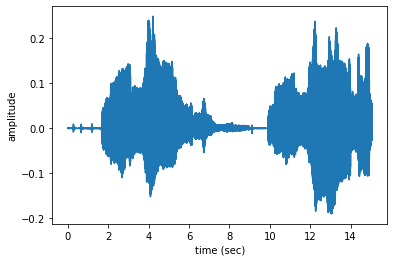

In [ ]:
# plot one of the audio signals 
n=7
fs = None # Sampling frequency. 
x, fs = librosa.load(files_ps[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files_ps[n]))

In [ ]:
# check this song has the correct song label in the dataframe
MLENDPS_df.loc[files_ps[n].split('/')[-1]]

song    Potter
Name: S119_hum_1_Potter.wav, dtype: object

The song being hummed is Potter which matches the label in the dataframe.

### Feature extraction 

At this stage we extract thirteen audio features:

Power, Tempo, Fraction of voiced region and the mean and standard deviation of:

1.   Spectral Centroid.
2.   Spectral bandwidth.
3.   Rolloff.
4.   Zero-crossing rate.
5.   Pitch.


In [ ]:
# create function that gets pitch of an audio signal
def getPitch(x,fs,winLen=0.02):
  winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
# get more features  
def getXyMore(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]

  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = labels_file.loc[fileID]['song'] == 'Potter' # T for potter F for Starwars  

    fs = None 
    # x is audio time series, fs is sampling rate of x 
    x, fs = librosa.load(file,sr=fs) # loads an audio file as a floating point time series
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    # these are the 4 extracted features from the MLEND starter kit  
    power = np.sum(x**2)/len(x) 
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    # we add 9 additional features to extract 
    spec_cent = librosa.feature.spectral_centroid(x, fs)
    spec_cent_mean = np.nanmean(spec_cent) if np.mean(np.isnan(spec_cent))<1 else 0
    spec_cent_std = np.nanstd(spec_cent) if np.mean(np.isnan(spec_cent))<1 else 0
    spec_bw = librosa.feature.spectral_bandwidth(x, fs)
    spec_bw_mean = np.nanmean(spec_bw) if np.mean(np.isnan(spec_bw))<1 else 0
    spec_bw_std = np.nanstd(spec_bw) if np.mean(np.isnan(spec_bw))<1 else 0
    rolloff = librosa.feature.spectral_rolloff(x, fs)
    rolloff_mean = np.nanmean(rolloff) if np.mean(np.isnan(rolloff))<1 else 0
    rolloff_std = np.nanstd(rolloff) if np.mean(np.isnan(rolloff))<1 else 0 
    zcr = librosa.feature.zero_crossing_rate(x)
    zcr_mean = np.nanmean(zcr) if np.mean(np.isnan(zcr))<1 else 0
    zcr_std = np.nanstd(zcr) if np.mean(np.isnan(zcr))<1 else 0
    onset_env = librosa.onset.onset_strength(x, fs)
    tempo = float(librosa.beat.tempo(onset_envelope=onset_env, sr=fs))

    xi = [power, pitch_mean, pitch_std, voiced_fr, spec_cent_mean, spec_cent_std, 
          spec_bw_mean, spec_bw_std, rolloff_mean, rolloff_std, zcr_mean, zcr_std, tempo]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
X_m, y_m = getXyMore(files_ps, labels_file=MLENDPS_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 824/824 [46:48<00:00,  3.41s/it]


In [ ]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp: 
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

We saved the feature matrix and label vector as pkl files

In [ ]:
save_object(X_m, '/content/drive/MyDrive/Data/MLEndPS/Hums_Whistles_X_m.pkl')
save_object(y_m, '/content/drive/MyDrive/Data/MLEndPS/Hums_Whistles_y_m.pkl')

We can then load the pkl files so we do not need to perform feature extraction again.

In [2]:
X_read = open("/content/drive/MyDrive/Data/MLEndPS/Hums_Whistles_X_m.pkl", "rb")
X_loaded = pickle.load(X_read)

X_read.close()

In [3]:
y_read = open("/content/drive/MyDrive/Data/MLEndPS/Hums_Whistles_y_m.pkl", "rb")
y_loaded = pickle.load(y_read)

y_read.close()

We check the shape of our predictor matrix and label vector.

In [4]:
print('The shape of X is', X_loaded.shape) 
print('The shape of y is', y_loaded.shape)


The shape of X is (824, 13)
The shape of y is (824,)


As you can see, we have 824 items consisting of thirteen features (stored in predictor matrix `X`) and one binary label (stored in label vector `y`). 

Next we check if our dataset is balanced.

In [5]:
print(' The number of Potter recordings is ', np.count_nonzero(y_loaded))
print(' The number of StarWars recordings is ', y_loaded.size - np.count_nonzero(y_loaded))

 The number of Potter recordings is  411
 The number of StarWars recordings is  413


The two datasets are almost equal in size, there are 2 more Starwars recordings than Potter recordings.

### Next we use feature selection to get the five most relevant features, using a random forest classifier as the model.

We split the training dataset into training and validation datasets so we can use the training dataset for feature selection and training.

In [6]:
from sklearn.model_selection import train_test_split

In [18]:
# split the dataset into training and validation 
X_train, X_val, y_train, y_val = train_test_split(X_loaded,y_loaded,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((576, 13), (248, 13), (576,), (248,))

In [17]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
# build a model 
estimator = RandomForestClassifier(n_estimators = 200)
selector = RFE(estimator, n_features_to_select=5, step =1) # select 5 features 
selector = selector.fit(X_train, y_train) # fit model  

# get dataframe for results 
features = ['power', 'pitch_mean', 'pitch_std', 'voiced_fr', 'spec_cent_mean', 'spec_cent_std', 
            'spec_bw_mean', 'spec_bw_std', 'rolloff_mean', 'rolloff_std', 'zcr_mean','zcr_std', 'tempo']
            
RFE_results = []
n_features = X_train.shape[1]
for x in range (n_features):
  RFE_results.append({'Feature': features[x],
                      'Selected': selector.support_[x],
                      'RFE_rank': selector.ranking_[x]})

df_RFE = pd.DataFrame(RFE_results)
df_RFE



,Feature,Selected,RFE_rank
0,power,True,1
1,pitch_mean,True,1
2,pitch_std,True,1
3,voiced_fr,False,3
4,spec_cent_mean,False,6
5,spec_cent_std,False,7
6,spec_bw_mean,False,2
7,spec_bw_std,False,4
8,rolloff_mean,False,8
9,rolloff_std,False,9


We see that the following five features have been selected as relevant:
1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Zero crossing rate mean.
5.   Tempo. 

We now modify the feature matrices of our train and validation datasets so that they only include the five relevant features. 

In [19]:
X_train = X_train[:][:,[0,1,2,10,12]]
X_val = X_val[:][:,[0,1,2,10,12]]
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((576, 5), (248, 5), (576,), (248,))

# Results

### Modelling: Random Forest Classifier (RFC)
We fit an RFC ensemble and print both its training and validation accuracy.



In [20]:
# without normalisation 
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
print('Training accuracy (RFC): {}.'.format(rfc.score(X_train, y_train)))
print('Validation accuracy (FRC): {}.'.format(rfc.score(X_val, y_val)))

Training accuracy (RFC): 1.0.
Validation accuracy (FRC): 0.7862903225806451.


We normalise the predictors to see if the performance improves. 

In [21]:
# with normalisation 
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train_n = (X_train-mean)/sd
X_val_n  = (X_val-mean)/sd # using same parameters as training 

rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(X_train_n,y_train)

print('Training Accuracy (RFC, normalised predictors): {}'.format(rfc.score(X_train_n, y_train)))
print('Validation  Accuracy(RFC, normalised predictors): {}'.format(rfc.score(X_val_n, y_val)))

Training Accuracy (RFC, normalised predictors): 1.0
Validation  Accuracy(RFC, normalised predictors): 0.7862903225806451


### Modelling: SVM
We do the same for a SVM model.

In [22]:
from sklearn import svm
# without normalisation 
model_svm  = svm.SVC(C=1, kernel = 'poly')
model_svm.fit(X_train,y_train)

print('Training Accuracy (SVM): {}'.format(model_svm.score(X_train, y_train)))
print('Validation  Accuracy (SVM): {}'.format(model_svm.score(X_val, y_val)))
print('The support vectors are: {}'.format(model_svm.support_vectors_.shape))

Training Accuracy (SVM): 0.7048611111111112
Validation  Accuracy (SVM): 0.7217741935483871
The support vectors are: (437, 5)


In [23]:
# with normalisation 
model_svm  = svm.SVC(C=1, kernel='poly')
model_svm.fit(X_train_n,y_train)

print('Training Accuracy (SVM, normalised predictors): {}'.format(model_svm.score(X_train_n, y_train)))
print('Validation  Accuracy (SVM, normalised predictors): {}'.format(model_svm.score(X_val_n, y_val)))
print('The support vectors are: {}', model_svm.support_vectors_.shape)

Training Accuracy (SVM, normalised predictors): 0.7430555555555556
Validation  Accuracy (SVM, normalised predictors): 0.7419354838709677
The support vectors are: {} (397, 5)


### Modelling: kNN
We do the same for a kNN model, but first we use k-fold cross-validation to select the best hyperparamter, k. 

In [24]:
# without normalisation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

knn_3 = KNeighborsClassifier(n_neighbors = 3)
knn_5 = KNeighborsClassifier(n_neighbors =5)
knn_7 = KNeighborsClassifier(n_neighbors = 7)

result_3 = cross_validate(knn_3, X_train, y_train, cv=5) # five folds 
result_5 = cross_validate(knn_5, X_train, y_train, cv=5)  
result_7 = cross_validate(knn_7, X_train, y_train, cv=5)

print('Average accuracy across folds (k = 3): {0}.'.format(result_3['test_score'].mean()))
print('Average accuracy across folds (k = 5): {0}.'.format(result_5['test_score'].mean()))
print('Average accuracy across folds (k = 7): {0}.'.format(result_7['test_score'].mean()))

Average accuracy across folds (k = 3): 0.7048725637181409.
Average accuracy across folds (k = 5): 0.7430584707646177.
Average accuracy across folds (k = 7): 0.741304347826087.


In [25]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing 

# with normalisation 
# use pipeline so parameters of normalisation are fixed from the training dataset
knn_3_pipe = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors = 3))
knn_5_pipe = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors = 5))
knn_7_pipe = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors = 7))

result_3 = cross_validate(knn_3_pipe, X_train, y_train, cv = 5) 
result_5 = cross_validate(knn_5_pipe, X_train, y_train, cv = 5)
result_7 = cross_validate(knn_7_pipe, X_train, y_train, cv = 5)

print('Average accuracy across folds (k = 3) (normalised predictors): {}.'.format(result_3['test_score'].mean()))
print('Average accuracy across folds (k = 5) (normalised predictors): {}.'.format(result_5['test_score'].mean()))
print('Average accuracy across folds (k = 7) (normalised predictors): {}.'.format(result_7['test_score'].mean()))

Average accuracy across folds (k = 3) (normalised predictors): 0.7117241379310344.
Average accuracy across folds (k = 5) (normalised predictors): 0.7325487256371814.
Average accuracy across folds (k = 7) (normalised predictors): 0.7395502248875562.


Based on the above, we choose a k of 7 and use normalised predictors.

In [26]:
# with normalisation 
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_n, y_train)
print('Training accuracy (kNN, normalised predictors): {}'.format(knn.score(X_train_n, y_train)))
print('Validation accuracy (kNN, normalised predictors): {}'.format(knn.score(X_val_n, y_val)))

Training accuracy (kNN, normalised predictors): 0.8177083333333334
Validation accuracy (kNN, normalised predictors): 0.7782258064516129
